<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import os

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif False:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

TF version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Found GPU at: /device:GPU:0


In [2]:
import itertools
import os

import numpy as np
pi = np.pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_probability as tfp
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz
from scipy.optimize import minimize_scalar
from scipy.ndimage import rotate

!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
!pip install --quiet --upgrade anisotropic-distance-transform
import fontParts
import extractor
import defcon
import adt
from ufo2ft import compileOTF

from tensorfont import Font

print("✓ Dependencies imported.")

✓ Dependencies imported.


In [3]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [4]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "bdghijlmnopqu" # straight letters only
#glyph_char_list = "abgjqrst"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
glyph_char_list = "abcz"

# ==== Create Font ====
factor = 1.8 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 1
sample_distance_deltas = [-1, 0, 2]
sample_distance_factors = [.8, 1., 2.0]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 5
n_b_scales = 1
n_v1_orientations = 8
n_v4_scales = 8

Box size: 143 × 289


In [5]:
def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_v1_scales):
        min_sigma = 0.7
        max_sigma = box_width / 15
        sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_v1_scales - 1)**2 + min_sigma)
        #sigmas.append((max_sigma - min_sigma) * s / n_v1_scales + min_sigma)
    return np.array(sigmas)

print("Spatial frequency scales:", get_sigmas())

def get_v1_filter_bank(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                             [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]])
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
        y += 0.5 # 0 if box_height % 2 == 0 else 0.5
        x += 0.5 # 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(s, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.

        # First derivative (odd filter/up-down)
        d1_space = np.exp(-(x**2+y**2)/(2*s**2))*x/(2*pi*s**4)
        d1_relu_sum = np.sum(d1_space * (d1_space > 0))
        d1 = np.fft.fft2(np.fft.ifftshift(d1_space + 1j * np.zeros_like(d1_space)))

        # Second derivative (even filter/mexican hat):
        s2 = s * .85 # To make them about the same width
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2_relu_sum = np.sum(d2_space * (d2_space > 0))
        d2 = (d1_relu_sum / d2_relu_sum) * np.fft.fft2(np.fft.ifftshift(d2_space + 1j * np.zeros_like(d2_space)))

        return (d1 + 1j*d2) / (np.max(tf.abs(d1+1j*d2))) # Max output should be about 0.2, which leaves lots of flexibility for the HRA later

    filter_bank = np.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 20
        fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))

    sigmas = get_sigmas()
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter(sigma, o)
            if display_filters:
                mx = np.max(np.abs(np.imag(np.fft.ifft2(f))))
                ax[s*2, o].imshow(np.real(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()

    return filter_bank.astype(np.complex64)

filter_bank = get_v1_filter_bank(0, display_filters=False)


def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    bdsohw_input_image = input_image[None, None, None, None, :, :]

    # pad image to filter size, which is 2*box_height, 2*box_width (to prevent too much wrapping)
    padded_input = tf.pad(bdsohw_input_image, [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    input_in_freqdomain = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(padded_input, tf.zeros_like(padded_input))))

    padded_result = tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :])

    presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], [2, 3])

    return presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

Spatial frequency scales: [ 0.7         1.86041667  5.34166667 11.14375    19.26666667]


100%|██████████| 4/4 [00:00<00:00, 327.05it/s]

  ✓ 4 glyphs rendered.



100%|██████████| 4/4 [00:00<00:00, 1487.47it/s]

  ✓ 4 glyphs measured.



100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

  ✓ 4 glyphs filtered.



100%|██████████| 4/4 [00:09<00:00,  2.41s/it]

  ✓ 4 glyphs distance-mapped.


local target dists


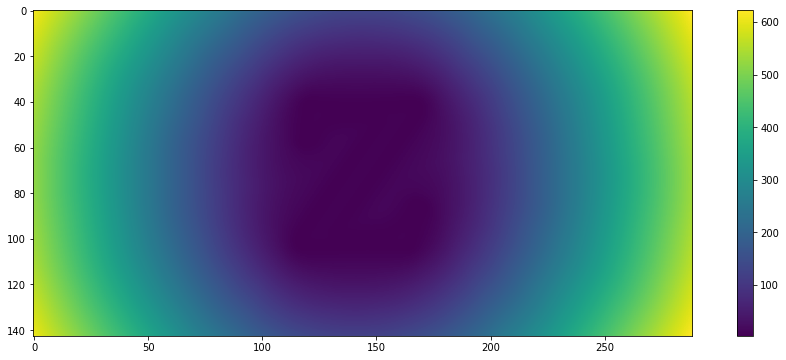

local target strengths


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: RuntimeWarning: divide by zero encountered in log


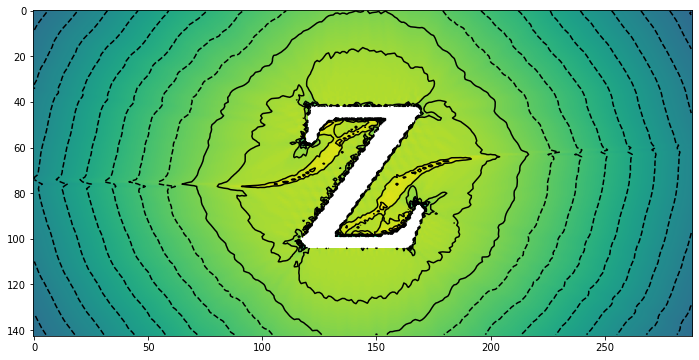

local mean


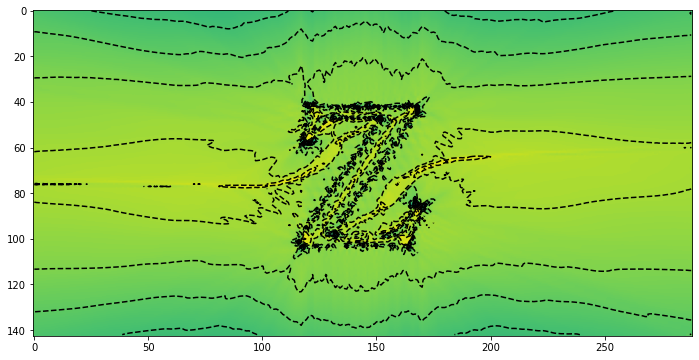

In [6]:

# 1. Render glyphs

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

def get_v1_response(glyph_image):
    """Returns a np.array of shape [n_v1_scales, n_v1_orientations, box_height, box_width] and type complex64,
    containing the local responses to the V1 filter bank (after inverse Fourier transform, i.e. in the spatial domain)."""
    with tf.device("/gpu:0"):
        filtered = apply_filter_bank(glyph_image, filter_bank)
    return filtered

# TODO: apply collinearity filter and use it to modulate the V1 results before applying the EDT.
# For now, we wil instead use the unweighted sum approximation for the distance.
def get_distance_and_strength_maps(v1_response):
    v1_scale_coeffs = np.array([0.8, 0.4, 0.2, 0.1, .05]) # could be extended to orientations, too!
    v1_pre_log_exps = np.array([1, 1, 1, 1, 1])*10

    adts = np.zeros((n_v1_orientations*2, box_height, box_width))
    ga = np.float32(np.abs(v1_response))
    for oi in range(n_v1_orientations):
        for oid in range(2):
            # we need to compute the l/r/t/b direction of the respective distance transform now!
            angle = ((pi*oi/n_v1_orientations) + (pi if oid == 1 else 0.0))
            angle_deg = angle * 180/np.pi
            rotated = rotate(ga[:, oi, :, :], angle_deg, axes=(1,2), reshape=True)
            vert_pad = int(np.round(np.abs(np.sin(2*angle)) * box_width / 2))
            hori_pad = int(np.round(np.abs(np.sin(2*angle)) * box_height / 2))
    
            for si in range(n_v1_scales):
                gas = rotated[si, :, :]
                gas /= np.max(gas)
                m = 1e20
    
                gas[gas >= 1e-20] **= v1_pre_log_exps[si]
                gas[gas >= 1e-20] = -np.log(gas[gas >= 1e-20])
                gas[gas < 1e-20] = m
                gas = np.float32(gas)
                adt.adt(gas, 10, 1, 1, 1)
                gas = rotate(gas, -angle_deg, reshape=True, mode='nearest') 
                gas = gas[vert_pad:(box_height+vert_pad), hori_pad:(box_width+hori_pad)]
    
                # Then, keep track of this distance transform 
                adts[oid*n_v1_orientations+oi, :, :] += gas * v1_scale_coeffs[si]
    
    # Now we have lots of different results for each orientation
    dists = np.zeros_like(adts)
    strengths = np.zeros_like(adts)
    
    for oi in range(2*n_v1_orientations):
        if False:
            fig, ax = plt.subplots(figsize=(16, 16))
            plt.imshow(-np.abs(glyph_v1_responses[egl])[0,oi%2,:,:], cmap="gray")
            plt.contour(np.log(adts)[oi, :, :], 30, cmap='gray')
            #plt.imshow(rel, cmap='RdBu', alpha=0.3)
            plt.colorbar()
            plt.show()
    
        angle = (pi*oi/n_v1_orientations)
        gy, gx = np.gradient(adts[oi, :, :])
        grad_angle = (np.arctan2(gy, gx) +2*np.pi) % (2*np.pi)
        angle_diff = -np.minimum(2*np.pi-np.abs(grad_angle-angle), np.abs(grad_angle-angle))
    
        if False:
            print("angle", angle)
            fig, ax = plt.subplots(figsize=(16, 16))
            plt.imshow(-glyph_images[egl], cmap="gray")
            plt.imshow(grad_angle, cmap='RdBu', alpha=0.3)
            plt.colorbar()
            plt.show()
    
        if False:
            print("angle diff", angle_diff)
            fig, ax = plt.subplots(figsize=(16, 16))
            plt.imshow(-glyph_images[egl], cmap="gray")
            plt.imshow(angle_diff**2, cmap='Reds', alpha=0.3)
            plt.colorbar()
            plt.show()
    
    
        dists[oi,:,:] = adts[oi,:,:]
        #rel = np.exp(-np.abs(angle_diff)**2)
        k = 16
        strengths[oi,:,:] = np.exp(k*np.cos(angle_diff)) / (2*np.pi*np.i0(k))
        strengths[strengths < 0] = 0
    
        if False:
            print("strengths")
            fig, ax = plt.subplots(figsize=(16, 16))
            #plt.imshow(-glyph_images[egl], cmap="gray")
            plt.imshow(strengths[oi,:,:], cmap='Reds', alpha=0.3)
            plt.contour(np.log(adts)[oi, :, :], 30, cmap='gray')
            plt.colorbar()
            plt.show()
            
    
    T = -0
    #local_target_dists = np.sum(dists * strengths * np.exp(-T*dists)/(np.sum(strengths * np.exp(-T*dists), (0))[None,:,:]), (0))[None,:,:]
    local_target_dists = np.sum(dists * np.exp(-T*strengths)/(np.sum(np.exp(-T*strengths), (0), keepdims=True)), (0), keepdims=True)
    adjusted_strengths = np.sum(strengths * np.exp(-(dists - local_target_dists)**2 / (local_target_dists*50)), (0))

    # now we want to use adjusted strengths to find the left and right strengths.
    # If either left and right are both zero, or both equally strong, we want the resulting adjusted strength to be zero,
    # because it doesn't represent a G-cell that is relevant to measuring the gap.
    # In addition, we will want to adjust the distances depending on the angle they came from, to accommodate things like VA.

    # TODO: use the angleuse this thing in order to zero out the strengths of within-counter G-cells
    # For now, just measure the mean sin of the angles.
    angles = np.arange(n_v1_orientations) * pi / n_v1_orientations
    angles = np.concatenate([angles, angles])[:, None, None]
    mean_sines = np.sin(np.sum(adjusted_strengths * angles / np.sum(adjusted_strengths, (0), keepdims=True), (0)))

    return (local_target_dists[0,:,:], adjusted_strengths, mean_sines)
    
glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)
glyph_v1_responses = {c: get_v1_response(glyph_images[c]) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs filtered.", flush=True)

glyph_v4_distances = {}
glyph_v4_fullnesses = {}
glyph_v4_mean_sines = {}
for c in tqdm(glyph_char_list):
    (dists, strengths, mean_sines) = get_distance_and_strength_maps(glyph_v1_responses[c])
    glyph_v4_distances[c] = dists
    glyph_v4_fullnesses[c] = strengths * (1 - glyph_images[c])
    glyph_v4_mean_sines[c] = mean_sines

print("  ✓", len(glyph_char_list), "glyphs distance-mapped.", flush=True)

egl = "z"
print("local target dists")
fig, ax = plt.subplots(figsize=(16, 6))
plt.imshow(glyph_v4_distances[egl])
#plt.contour(glyph_v4_distances[egl], 20, colors='k')
plt.colorbar()
plt.show()
print("local target strengths")
fig, ax = plt.subplots(figsize=(16, 6))
plt.imshow(np.log(glyph_v4_fullnesses[egl]))
plt.contour(np.log(glyph_v4_fullnesses[egl]), 20, colors='k')
plt.show()

print("local mean")
fig, ax = plt.subplots(figsize=(16, 6))
plt.imshow(np.log(glyph_v4_mean_sines[egl]))
plt.contour(np.log(glyph_v4_mean_sines[egl]), 20, colors='k')
plt.show()


In [7]:
# 2. Assemble pairs

def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)
    
left_images = []
right_images = []
left_v1_responses = []
right_v1_responses = []
left_v4_distances = []
right_v4_distances = []
left_v4_fullnesses = []
right_v4_fullnesses = []
left_v4_mean_sines = []
right_v4_mean_sines = []
left_translations = []
right_translations = []

for c1 in tqdm(glyph_char_list):
    for c2 in reversed(glyph_char_list):
        left_images.append(glyph_images[c1])
        right_images.append(glyph_images[c2])
        left_v1_responses.append(glyph_v1_responses[c1])
        right_v1_responses.append(glyph_v1_responses[c2])
        left_v4_distances.append(glyph_v4_distances[c1])
        right_v4_distances.append(glyph_v4_distances[c2])
        left_v4_fullnesses.append(glyph_v4_fullnesses[c1])
        right_v4_fullnesses.append(glyph_v4_fullnesses[c2])
        left_v4_mean_sines.append(glyph_v4_mean_sines[c1])
        right_v4_mean_sines.append(glyph_v4_mean_sines[c2])

        lt, rt = get_pair_translations(c1, c2, sample_distance_deltas, None) # sample_distance_factors) #sample_distance_deltas
        left_translations.append(lt)
        right_translations.append(rt)

print("  ✓", len(glyph_char_list)**2, "pairs assembled.")

# 3. Set up generator to yield pairs, and wrap generator in a tf.Dataset

def return_pair():
    i = 0
    while i < len(left_images):
        yield {
            "left_image": left_images[i],
            "right_image": right_images[i],
            "left_v1_response": left_v1_responses[i],
            "right_v1_response": right_v1_responses[i],
            "left_v4_distance": left_v4_distances[i],
            "right_v4_distance": right_v4_distances[i],
            "left_v4_fullness": left_v4_fullnesses[i],
            "right_v4_fullness": right_v4_fullnesses[i],
            "left_v4_mean_sines": left_v4_mean_sines[i],
            "right_v4_mean_sines": right_v4_mean_sines[i],
            "left_translations": left_translations[i],
            "right_translations": right_translations[i],
        }
        i = (i + 1) % len(left_images)

dataset = tf.data.Dataset.from_generator(
     return_pair,
     {
      "left_image": tf.float32,
      "right_image": tf.float32,
      "left_v1_response": tf.complex64,
      "right_v1_response": tf.complex64,
      "left_v4_distance": tf.float32,
      "right_v4_distance": tf.float32,
      "left_v4_fullness": tf.float32,
      "right_v4_fullness": tf.float32,
      "left_v4_mean_sines": tf.float32,
      "right_v4_mean_sines": tf.float32,
      "left_translations": tf.int32,
      "right_translations": tf.int32,
     },
     {
      "left_image": tf.TensorShape([box_height, box_width]),
      "right_image": tf.TensorShape([box_height, box_width]),
      "left_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "right_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "left_v4_distance": tf.TensorShape([box_height, box_width]),
      "right_v4_distance": tf.TensorShape([box_height, box_width]),
      "left_v4_fullness": tf.TensorShape([box_height, box_width]),
      "right_v4_fullness": tf.TensorShape([box_height, box_width]),
      "left_v4_mean_sines": tf.TensorShape([box_height, box_width]),
      "right_v4_mean_sines": tf.TensorShape([box_height, box_width]),
      "left_translations": tf.TensorShape([n_sample_distances,]),
      "right_translations": tf.TensorShape([n_sample_distances,])
     },
)

print("\n  ✓ Dataset ready.")

100%|██████████| 4/4 [00:00<00:00, 234.46it/s]

  ✓ 16 pairs assembled.

  ✓ Dataset ready.


In [8]:
# 4. Apply horizontal translations in the dataset

def translate_4d_image(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, height, width>
    """

    images = tf.tile(input_image[:, :, :, :, None], [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_image.shape[3]] # positive shift: left-shift

    result = tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype)

    # Manually ensure that the width-dimension hasn't changed
    s = list(result.shape)
    s[-1] = box_width
    result.set_shape(s)

    return result

def apply_translations(d):
    d["left_image"] = translate_4d_image(d["left_image"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_image"] = translate_4d_image(d["right_image"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v1_response"] = translate_4d_image(d["left_v1_response"], d["left_translations"])
    d["right_v1_response"] = translate_4d_image(d["right_v1_response"], d["right_translations"])
    d["left_v4_distance"] = translate_4d_image(d["left_v4_distance"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_v4_distance"] = translate_4d_image(d["right_v4_distance"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v4_fullness"] = translate_4d_image(d["left_v4_fullness"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_v4_fullness"] = translate_4d_image(d["right_v4_fullness"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v4_mean_sines"] = translate_4d_image(d["left_v4_mean_sines"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_v4_mean_sines"] = translate_4d_image(d["right_v4_mean_sines"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    del d["left_translations"]
    del d["right_translations"]
    return (d, 0.)  # The zero here doesn't do anything and is just to make Keras happy, because model.fit expects a dataset of 2-tuples where the second entry is the target value.

translated_dataset = dataset.map(apply_translations)

print("dataset shapes:", translated_dataset.element_spec)

Instructions for updating:
Use fn_output_signature instead
dataset shapes: ({'left_image': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None), 'right_image': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None), 'left_v1_response': TensorSpec(shape=(3, 5, 8, 143, 289), dtype=tf.complex64, name=None), 'right_v1_response': TensorSpec(shape=(3, 5, 8, 143, 289), dtype=tf.complex64, name=None), 'left_v4_distance': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None), 'right_v4_distance': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None), 'left_v4_fullness': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None), 'right_v4_fullness': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None), 'left_v4_mean_sines': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None), 'right_v4_mean_sines': TensorSpec(shape=(3, 143, 289), dtype=tf.float32, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))


Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.2284Penalty for the scale/sinsum: todo


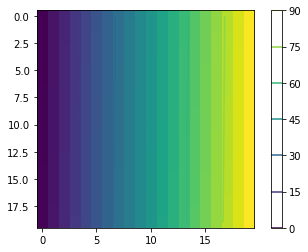

relevance self a b c 0.998954 1.000353 0.101086296


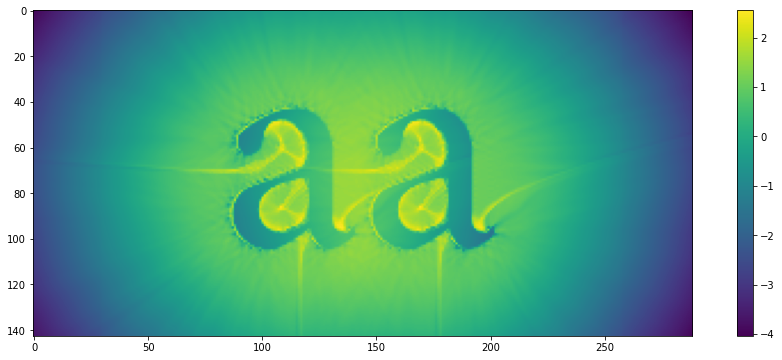

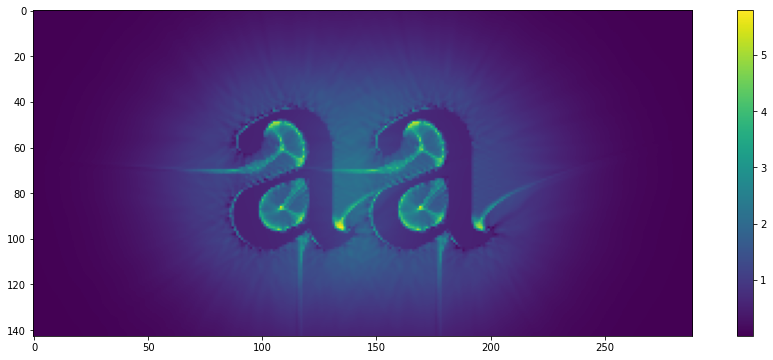

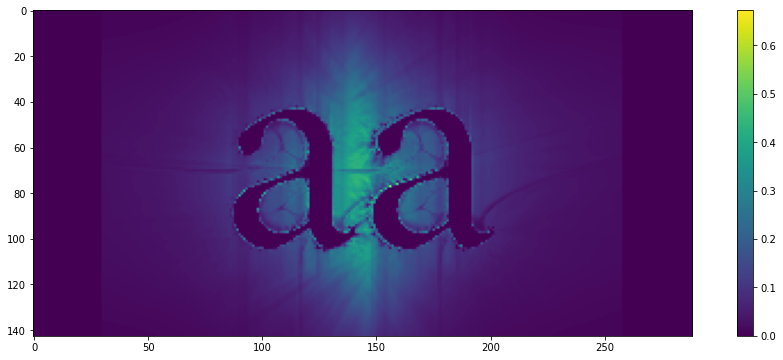

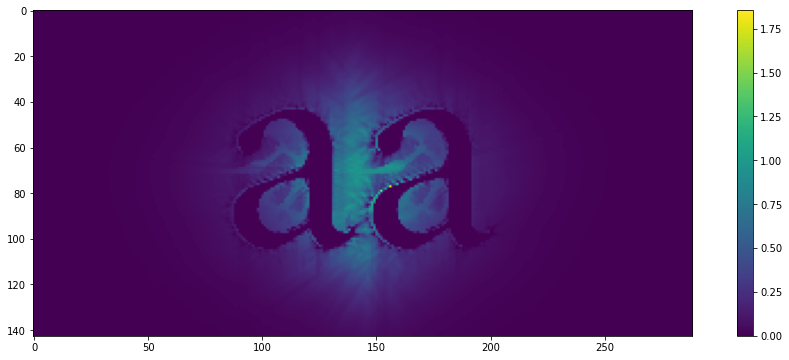

20/20 [==============================] - 12s 600ms/step - loss: 0.2284
Epoch 2/100
20/20 [==============================] - 4s 199ms/step - loss: 0.1246
Epoch 3/100
20/20 [==============================] - 4s 200ms/step - loss: 0.2218
Epoch 4/100
20/20 [==============================] - 4s 199ms/step - loss: 0.1440
Epoch 5/100
20/20 [==============================] - 4s 195ms/step - loss: 0.1313
Epoch 6/100
20/20 [==============================] - 4s 194ms/step - loss: 0.1844
Epoch 7/100
20/20 [==============================] - 4s 196ms/step - loss: 0.1000
Epoch 8/100
20/20 [==============================] - 4s 197ms/step - loss: 0.1211
Epoch 9/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0866
Epoch 10/100
20/20 [==============================] - 4s 196ms/step - loss: 0.0716
Epoch 11/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0821
Epoch 12/100
20/20 [==============================] - 4s 195ms/step - loss: 0.0565
Epoch 13/100
20/20 [====

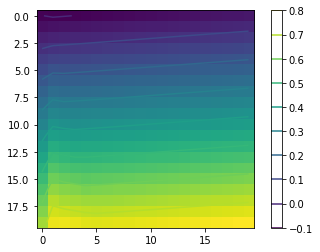

relevance self a b c 0.9902545 1.0035181 0.10943487


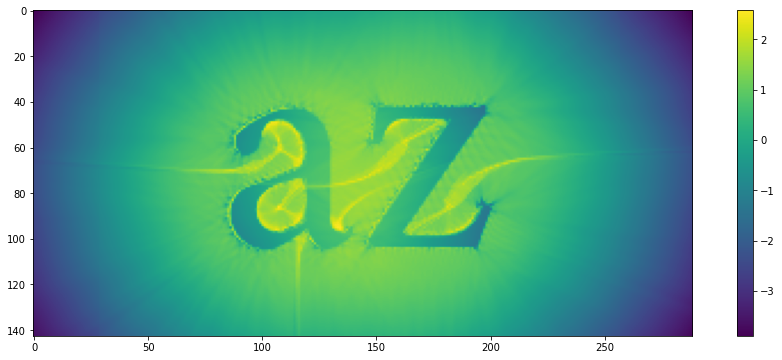

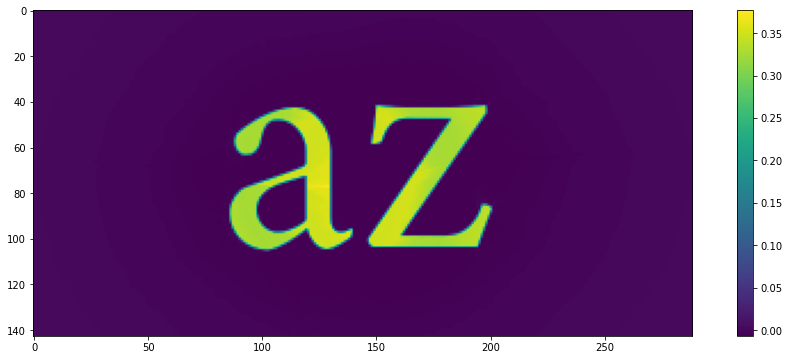

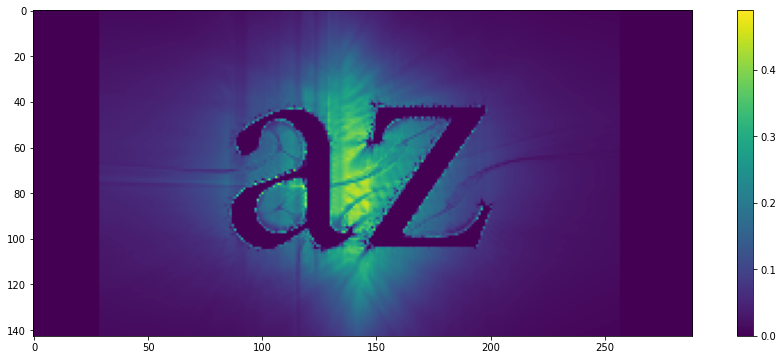

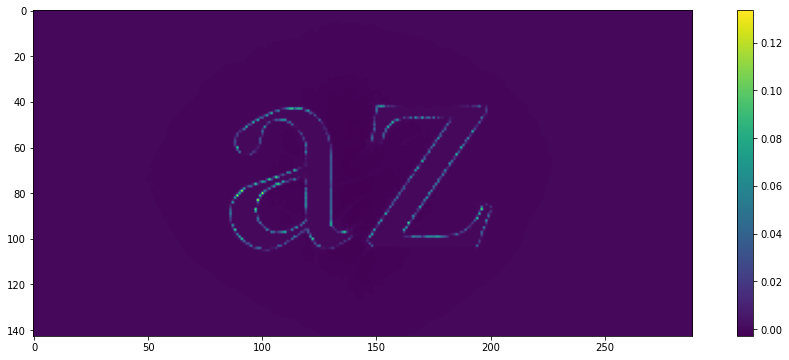

20/20 [==============================] - 6s 287ms/step - loss: 3.7241e-04
Epoch 24/100
20/20 [==============================] - 4s 194ms/step - loss: 3.2349e-04
Epoch 25/100
20/20 [==============================] - 4s 197ms/step - loss: 2.9931e-04
Epoch 26/100
20/20 [==============================] - 4s 199ms/step - loss: 8.3356e-04
Epoch 27/100
20/20 [==============================] - 4s 194ms/step - loss: 8.1620e-04
Epoch 28/100
20/20 [==============================] - 4s 189ms/step - loss: 3.9425e-04
Epoch 29/100
20/20 [==============================] - 4s 197ms/step - loss: 6.1274e-04
Epoch 30/100
20/20 [==============================] - 4s 196ms/step - loss: 4.2920e-04
Epoch 31/100
20/20 [==============================] - 4s 188ms/step - loss: 3.4313e-04
Epoch 32/100
20/20 [==============================] - 4s 195ms/step - loss: 4.9872e-04
Epoch 33/100
20/20 [==============================] - 4s 191ms/step - loss: 5.3112e-04
Epoch 34/100
20/20 [==============================] - 4s

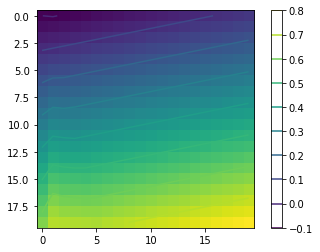

relevance self a b c 0.9901951 1.0034051 0.10943933


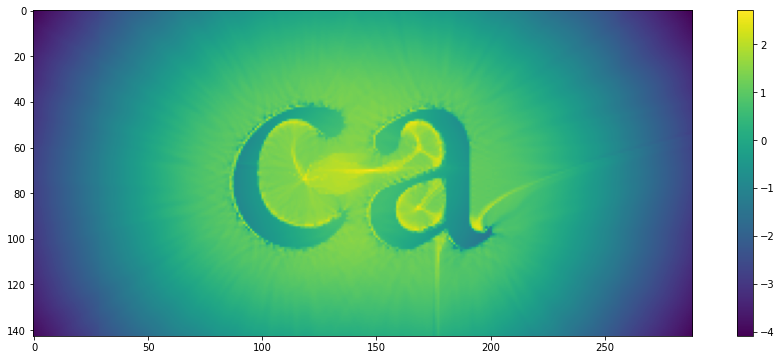

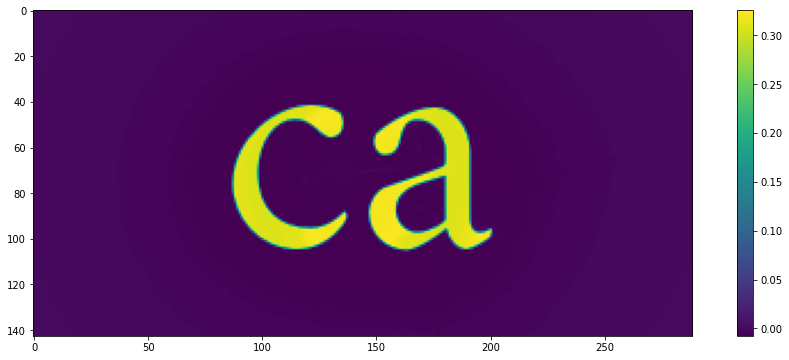

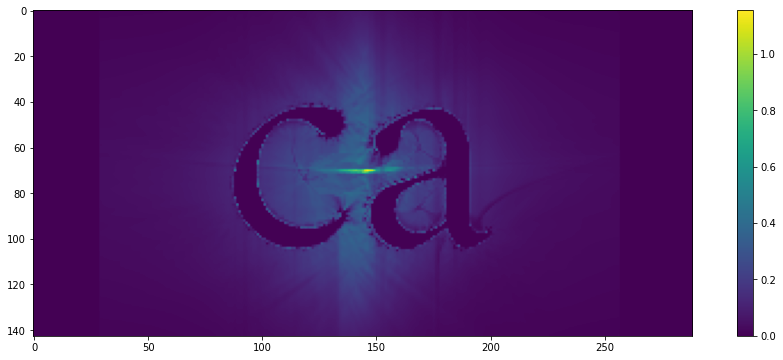

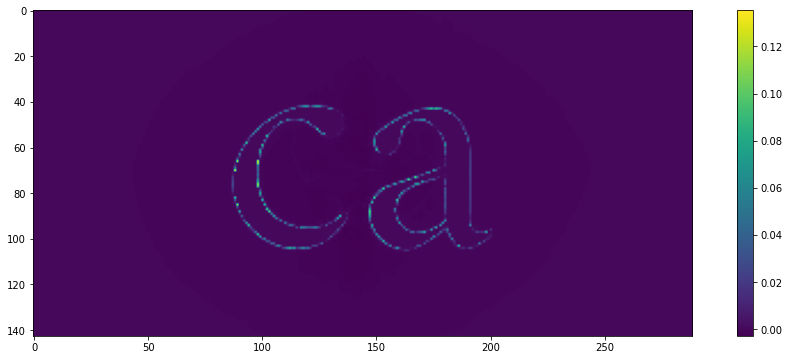

20/20 [==============================] - 6s 288ms/step - loss: 4.7089e-04
Epoch 46/100
20/20 [==============================] - 4s 195ms/step - loss: 3.4079e-04
Epoch 47/100
20/20 [==============================] - 4s 195ms/step - loss: 3.0278e-04
Epoch 48/100
20/20 [==============================] - 4s 202ms/step - loss: 3.2123e-04
Epoch 49/100
20/20 [==============================] - 4s 194ms/step - loss: 4.1453e-04
Epoch 50/100
20/20 [==============================] - 4s 195ms/step - loss: 3.2160e-04
Epoch 51/100
20/20 [==============================] - 4s 196ms/step - loss: 4.4794e-04
Epoch 52/100
20/20 [==============================] - 4s 194ms/step - loss: 2.9824e-04
Epoch 53/100
20/20 [==============================] - 4s 195ms/step - loss: 3.8336e-04
Epoch 54/100
20/20 [==============================] - 4s 195ms/step - loss: 3.5371e-04
Epoch 55/100
20/20 [==============================] - 4s 196ms/step - loss: 4.2379e-04
Epoch 56/100
20/20 [==============================] - 4s

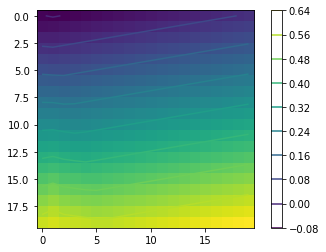

relevance self a b c 0.9901255 1.0032488 0.109433696


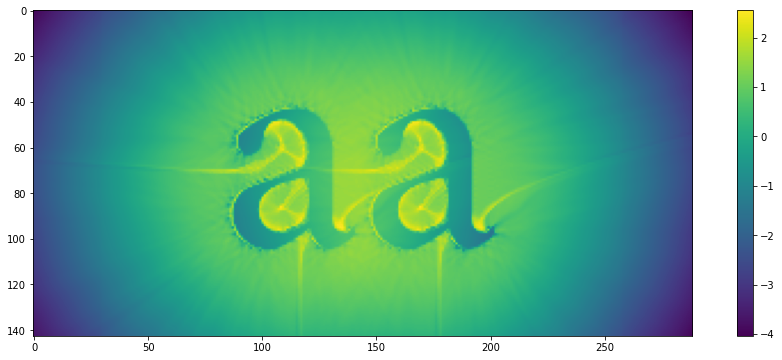

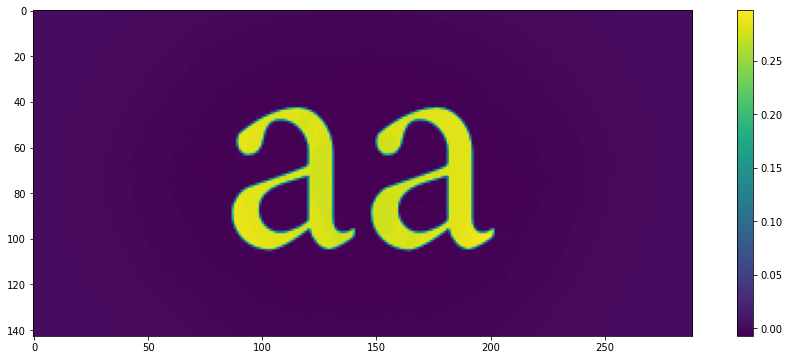

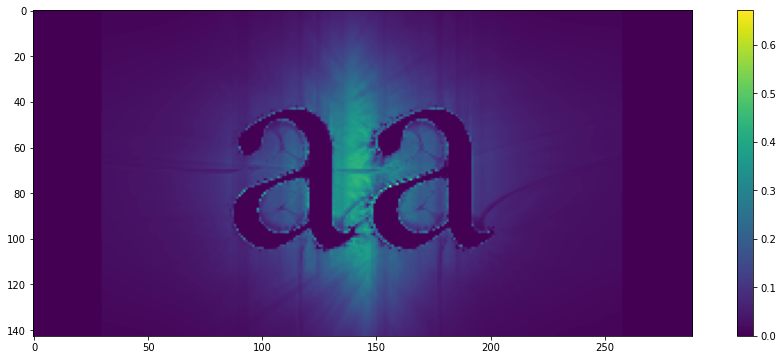

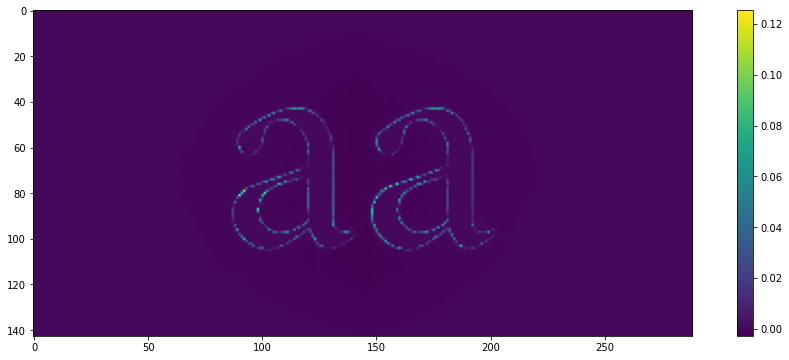

20/20 [==============================] - 6s 293ms/step - loss: 4.9586e-04
Epoch 68/100
20/20 [==============================] - 4s 191ms/step - loss: 3.0750e-04
Epoch 69/100
20/20 [==============================] - 4s 192ms/step - loss: 4.1961e-04
Epoch 70/100
20/20 [==============================] - 4s 193ms/step - loss: 4.1549e-04
Epoch 71/100
20/20 [==============================] - 4s 193ms/step - loss: 2.9922e-04
Epoch 72/100
20/20 [==============================] - 4s 191ms/step - loss: 2.9926e-04
Epoch 73/100
20/20 [==============================] - 4s 193ms/step - loss: 3.0100e-04
Epoch 74/100
20/20 [==============================] - 4s 193ms/step - loss: 8.0804e-04
Epoch 75/100
20/20 [==============================] - 4s 194ms/step - loss: 3.4691e-04
Epoch 76/100
20/20 [==============================] - 4s 199ms/step - loss: 3.5586e-04
Epoch 77/100
20/20 [==============================] - 4s 196ms/step - loss: 5.7877e-04
Epoch 78/100
20/20 [==============================] - 4s

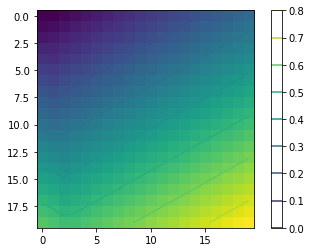

relevance self a b c 0.99004275 1.0030997 0.10946139


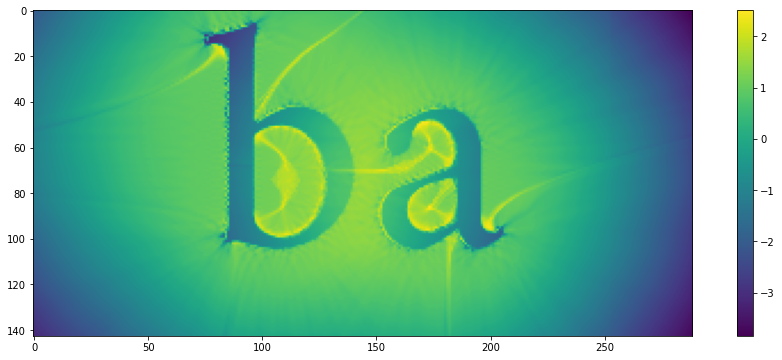

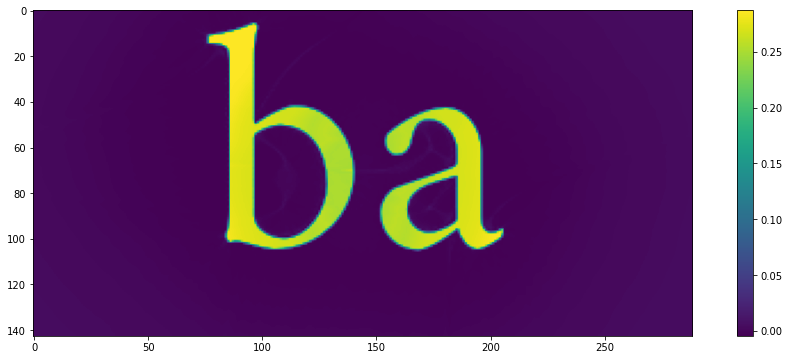

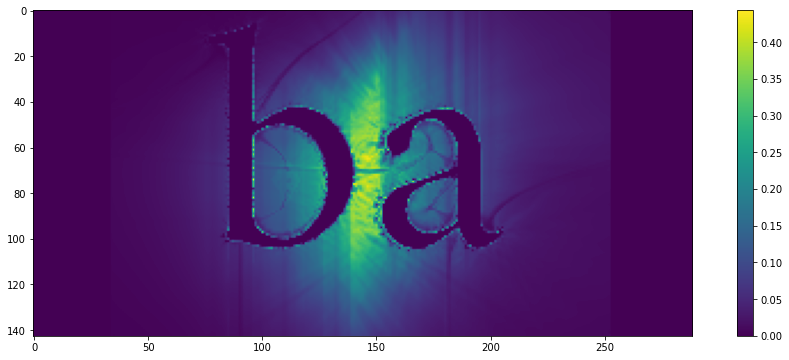

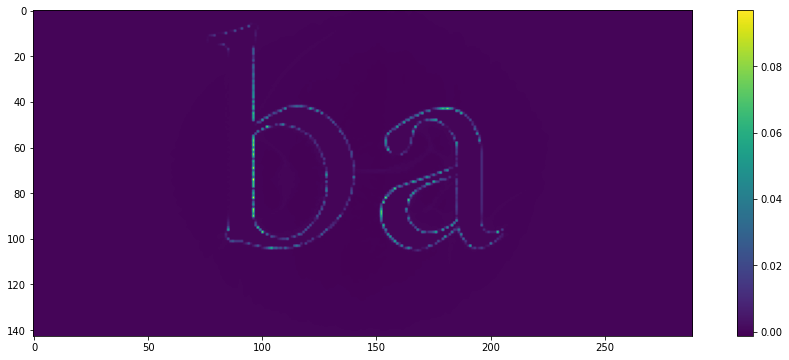

20/20 [==============================] - 6s 299ms/step - loss: 4.1710e-04
Epoch 90/100
20/20 [==============================] - 4s 193ms/step - loss: 3.5150e-04
Epoch 91/100
20/20 [==============================] - 4s 196ms/step - loss: 8.5395e-04
Epoch 92/100
20/20 [==============================] - 4s 193ms/step - loss: 3.2255e-04
Epoch 93/100
20/20 [==============================] - 4s 195ms/step - loss: 2.6930e-04
Epoch 94/100
20/20 [==============================] - 4s 193ms/step - loss: 5.1541e-04
Epoch 95/100
20/20 [==============================] - 4s 195ms/step - loss: 6.0022e-04
Epoch 96/100
20/20 [==============================] - 4s 196ms/step - loss: 7.3883e-04
Epoch 97/100
20/20 [==============================] - 4s 194ms/step - loss: 1.7171e-04
Epoch 98/100
20/20 [==============================] - 4s 195ms/step - loss: 4.2074e-04
Epoch 99/100
20/20 [==============================] - 4s 194ms/step - loss: 6.2577e-04
Epoch 100/100
20/20 [==============================] - 4

In [9]:
# 5. Utility functions
eps = np.finfo(np.float32).tiny

def invspa(t):
    return np.log(np.exp(t) - 1).astype(np.float32)

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def sp(t):
    return tf.nn.softplus(t)

# 6. Generating G-cell fragments

u, v = np.mgrid[-box_height/2:box_height/2,-box_width/2:box_width/2].astype(np.float32)
u = u / (box_width)
v = v / (box_width)
r = np.sqrt(u**2 + v**2)[None, None, None, None, :, :]

def make_losses_filters(g_spreads):
    return tf.exp(-r**2 / (2*g_spreads**2)) / (g_spreads * tf.math.sqrt(2.*3.14159276))

class RelevanceLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(RelevanceLayer, self).__init__(**kwargs)

        self.a = tf.Variable(1.)
        self.b = tf.Variable(1.)
        self.c = tf.Variable(.1)

    def print_weights(self):
        print("relevance self a b c", self.a.numpy(), self.b.numpy(), self.c.numpy())

    def call(self, inputs):
        (distsum, distdiff, strengthsum, strengthdiff, sinesum) = inputs

        equidistance = (1-distdiff/distsum) ** self.a
        equistrength = (1-strengthdiff/strengthsum) ** self.b
        
        out = equidistance * equistrength * strengthsum ** (1. + self.c * sinesum)

        return tf.reshape(out, [batch_size, n_sample_distances, box_height, box_width])

# 8. Cost layer
class PenaltyLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)
        #self.a = tf.Variable(1.0)
        #self.b = tf.Variable(1.0)
        self.d1 = tf.keras.layers.Dense(32, activation='relu')
        self.d2 = tf.keras.layers.Dense(32, activation='relu')
        self.d3 = tf.keras.layers.Dense(1)

    def print_weights(self):
        #print("Penalty a b:", self.a.numpy(), self.b.numpy())
        print("Penalty for the scale/sinsum: todo")
        distsums = tf.range(0, 200, 10, dtype=tf.float32)
        n_distsums = tf.shape(distsums)[0]
        sinesums = tf.range(0, 2, 0.1, dtype=tf.float32)
        n_sinesums = tf.shape(sinesums)[0]
        distsums, sinesums = tf.meshgrid(distsums, sinesums)
        inp = tf.stack([distsums, sinesums], axis=-1) # <dists, sines, 2>
        inp = tf.reshape(inp, [n_distsums * n_sinesums, 2])
        out = self.d3(self.d2(self.d1(inp)))
        out = tf.reshape(out, [n_distsums, n_sinesums])

        plt.imshow(out)
        plt.contour(out)
        plt.colorbar()
        plt.show()

    def call(self, inputs):
        (distsum, sinesum) = inputs  # both <n * d, h * w>
        inp = tf.stack([distsum, sinesum], axis=-1)  # <nd, hw, 3>
        out = self.d3(self.d2(self.d1(inp)))

        return tf.reshape(out, [batch_size, n_sample_distances, box_height, box_width])

# 9. Set up the actual math

def get_pair_violation_from_strength(left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness, left_v4_mean_sines, right_v4_mean_sines):
    # TODO: Give them each an exponent, weigh them by orientation and by scale, and sum them up.

    # What we are trying to do is, predict from these four values everywhere a penalty and a relevance.
    # So we need two networks, one to generate the penalty and one to generate the relevance.
    # Both of them take in four values locally
    distsum = tf.reshape(tf.identity(left_v4_distance + right_v4_distance, name="distsum"), [batch_size * n_sample_distances, box_height * box_width])
    distdiff = tf.reshape(tf.identity(tf.abs(left_v4_distance - right_v4_distance), name="distdiff"), [batch_size * n_sample_distances, box_height * box_width])
    strengthsum = tf.reshape(tf.identity(left_v4_fullness + right_v4_fullness, name="strengthsum"), [batch_size * n_sample_distances, box_height * box_width])
    strengthdiff = tf.reshape(tf.identity(tf.abs(left_v4_fullness - right_v4_fullness), name="strengthdiff"), [batch_size * n_sample_distances, box_height * box_width])
    sinesum = tf.reshape(tf.identity(tf.abs(left_v4_mean_sines + right_v4_mean_sines), name="sinesum"), [batch_size * n_sample_distances, box_height * box_width])
    
    pl = PenaltyLayer()
    penalty = tf.identity(pl((distsum, sinesum)), name="penalty") # returns <n, d, h, w>

    rl = RelevanceLayer()
    relevance = tf.identity(rl((distsum, distdiff, strengthsum, strengthdiff, sinesum)), name="relevance")

    weighted_penalty = tf.identity(penalty * relevance / (eps + tf.reduce_sum(relevance, axis=[2, 3], keepdims=True)), name="weighted_penalty")
    ys = tf.reduce_sum(weighted_penalty, axis=[2, 3])  # <n, d>

    # Find worst violation of the well
    up_first_ness = (ys[:, 1] - ys[:, 0])
    down_second_ness = (ys[:, 1] - ys[:, 2]) 
    worst_violation_sum = tf.reduce_mean((tf.reduce_max(tf.stack([up_first_ness, down_second_ness], axis=0), axis=[0]) + eps), name="worst_violation")
    return worst_violation_sum 

# 10. Set up Keras model and run

def get_keras_model():
    # The translated raw images aren't used in the model, they're just for visualization purposes ...
    left_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_image')
    right_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_image')

    # ... but the translated V1 responses are:
    left_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='left_v1_response', dtype=tf.complex64)
    right_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='right_v1_response', dtype=tf.complex64)
    left_v4_distance = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_v4_distance')
    right_v4_distance = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_v4_distance')
    left_v4_fullness = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_v4_fullness')
    right_v4_fullness = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_v4_fullness')
    left_v4_mean_sines = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_v4_mean_sines')
    right_v4_mean_sines = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_v4_mean_sines')

    # This calls the V4 layer, the penalty/reward layer, and finds the max cost
    #total_violation = tf.identity(get_pair_violation(left_v1_response, right_v1_response), "total_violation")
    total_violation = tf.identity(get_pair_violation_from_strength(left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness, left_v4_mean_sines, right_v4_mean_sines), "total_violation")

    return tf.keras.Model(inputs=[left_image, right_image, left_v1_response, right_v1_response, left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness, left_v4_mean_sines, right_v4_mean_sines], outputs=(total_violation))

class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, interval):
        self.dataset = dataset
        self.interval = interval
        self.current_data = None

    def get_val(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])([self.current_data["left_v1_response"],
                                                                           self.current_data["right_v1_response"],
                                                                           self.current_data["left_v4_distance"],
                                                                           self.current_data["right_v4_distance"],
                                                                           self.current_data["left_v4_fullness"],
                                                                           self.current_data["right_v4_fullness"],
                                                                           self.current_data["left_v4_mean_sines"],
                                                                           self.current_data["right_v4_mean_sines"],
                                                                           self.current_data["left_image"],
                                                                           self.current_data["right_image"]])[0]
        return output

    def get_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        l.print_weights()

    def on_epoch_end(self, epoch, logs=None):
        # Only show this stuff every [interval] batches
        if epoch % self.interval != 0:
            return

        self.current_data, _ = next(self.dataset) #list(self.dataset.take(1).as_numpy_iterator())[0]
        pair_images = self.current_data["left_image"] + self.current_data["right_image"]

        distsum = self.get_val("distsum")
        distdiff = self.get_val("distdiff")
        strengthsum = self.get_val("strengthsum")
        strengthdiff = self.get_val("strengthdiff")

        np.save("distsum", distsum)
        np.save("distdiff", distdiff)
        np.save("strengthsum", strengthsum)
        np.save("strengthdiff", strengthdiff)
        np.save("pair", pair_images)

        penalty = self.get_val("penalty")
        relevance = self.get_val("relevance")

        self.print_weights("penalty_layer")
        self.print_weights("relevance_layer")

        print("Dist sum")
        fig, ax = plt.subplots(figsize=(16, 6))
        plt.imshow(tf.math.log(distsum[0, 1, :, :]))
        plt.colorbar()
        plt.show()

        print("Penalty")
        fig, ax = plt.subplots(figsize=(16, 6))
        plt.imshow(penalty[0, 1, :, :])
        plt.colorbar()
        plt.show()

        print("relevance")
        fig, ax = plt.subplots(figsize=(16, 6))
        plt.imshow(relevance[0, 1, :, :])
        plt.colorbar()
        plt.show()

        print("penalty * relevance")
        fig, ax = plt.subplots(figsize=(16, 6))
        plt.imshow((penalty *relevance)[0, 1, :, :])
        plt.colorbar()
        plt.show()



model = get_keras_model()
testing = 0
model.compile(loss=(lambda _, c: c), optimizer=tf.keras.optimizers.Adam(0.2 if testing else .0001))


prepared_dataset = translated_dataset.shuffle(30*batch_size).batch(batch_size).prefetch(batch_size)

if True:
    history = model.fit(prepared_dataset,
                        callbacks=[MonitorProgressCallback(prepared_dataset.as_numpy_iterator(), 1 if testing else 22)],
                        epochs=(1 if testing else 100),
                        steps_per_epoch=(1 if testing else 20), use_multiprocessing=False)

distance error


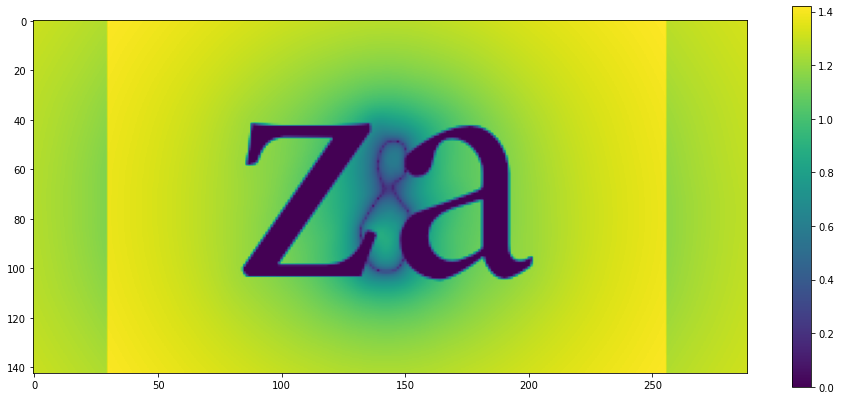

activation


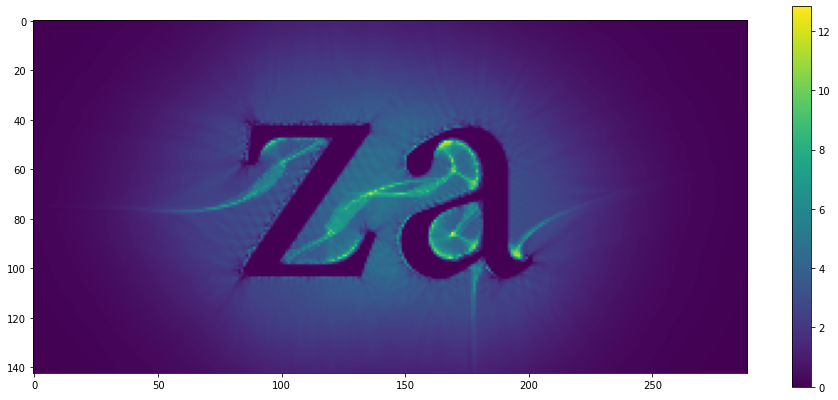

penalty


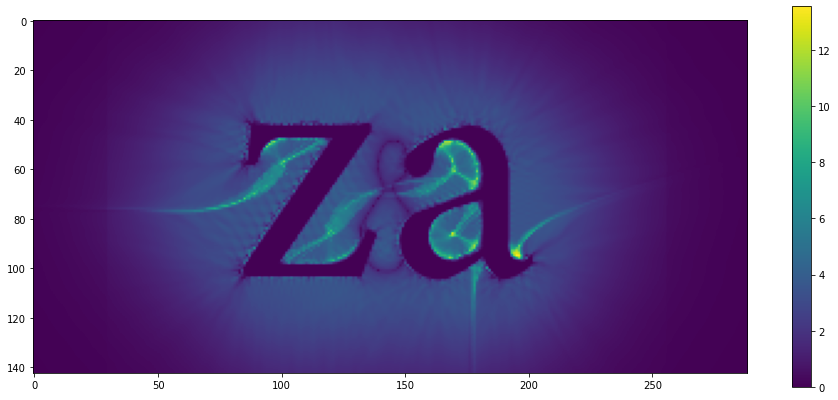

------------
equidistance


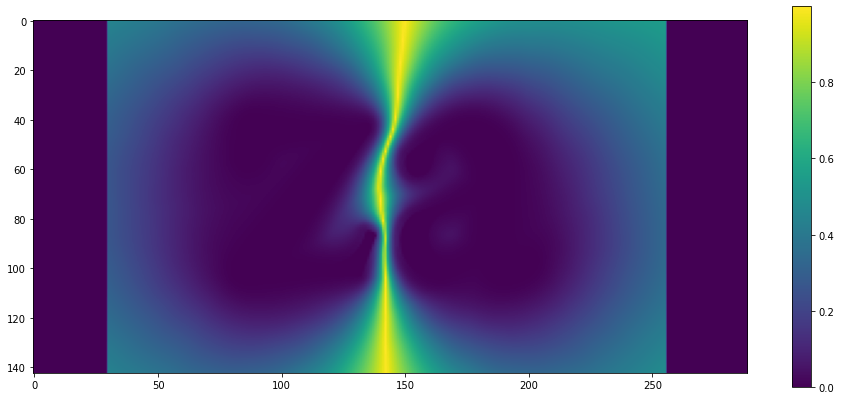

equistrength


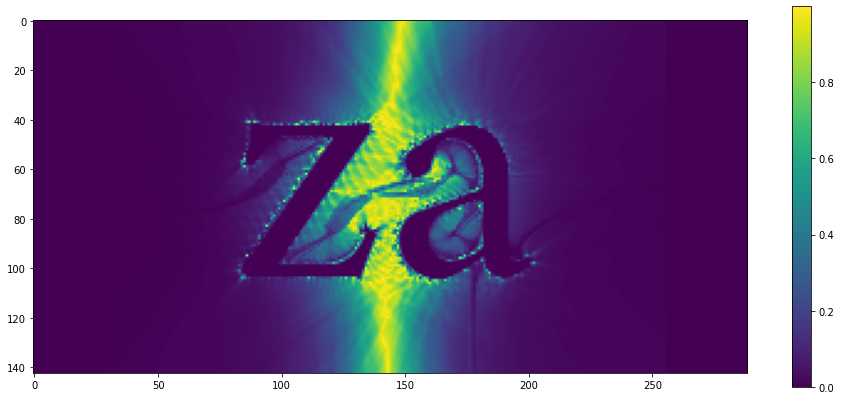

relevance


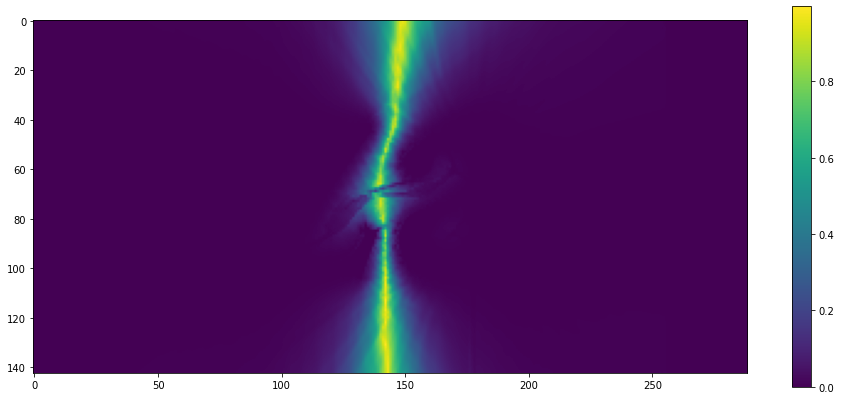

In [29]:
distsum = np.load("distsum.npy")
distdiff = np.load("distdiff.npy")
strengthsum = np.load("strengthsum.npy")
strengthdiff = np.load("strengthdiff.npy")
pair = np.load("pair.npy")
# Now we need to find good images for the penalty and the relevance.

# For the penalty, we are interested both in how right/wrong the scale is and how strong the activation is.
distance_error = (1-pair) * tf.abs(tf.math.log(distsum/40))**.3
activation = (1-pair) * strengthsum #/ distsum
penalty = distance_error * activation

print("distance error")
fig, ax = plt.subplots(figsize=(16, 7))
plt.imshow(distance_error[0,1,:,:])
plt.colorbar()
plt.show()

print("activation")
fig, ax = plt.subplots(figsize=(16, 7))
plt.imshow(activation[0,1,:,:])
plt.colorbar()
plt.show()

print("penalty")
fig, ax = plt.subplots(figsize=(16, 7))
plt.imshow(penalty[0,1,:,:])
plt.colorbar()
plt.show()


# For the relevance, we are interested in whether we are in the gap or not, and also whether the strength
# is evenly distributed between the two letters, because strength that binds mostly just one is not that useful.

equidistance = (1-pair) * (1-distdiff/distsum)**2
equistrength = (1-pair) * (1-strengthdiff/strengthsum)**2
relevance = equidistance * equistrength
print("------------")
print("equidistance")
fig, ax = plt.subplots(figsize=(16, 7))
plt.imshow(equidistance[0,1,:,:])
plt.colorbar()
plt.show()
print("equistrength")
fig, ax = plt.subplots(figsize=(16, 7))
plt.imshow(equistrength[0,1,:,:])
plt.colorbar()
plt.show()

print("relevance")
fig, ax = plt.subplots(figsize=(16, 7))
plt.imshow(relevance[0,1,:,:])
plt.colorbar()
plt.show()

loss_penalty tf.Tensor(0.93723756, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(1.5318897, shape=(), dtype=float32)
loss_penalty tf.Tensor(1.1858652, shape=(), dtype=float32) for distance 1.0 thanks to value tf.Tensor(1.4110256, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.06913991, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(2.2370553, shape=(), dtype=float32)
loss_penalty tf.Tensor(5.653982, shape=(), dtype=float32) for distance -4.2360680251559995 thanks to value tf.Tensor(4.8778105, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.06913991, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(2.2370553, shape=(), dtype=float32)
loss_penalty tf.Tensor(1.8811307, shape=(), dtype=float32) for distance -2.6180339844527367 thanks to value tf.Tensor(3.8715432, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.06913991, shape=(), dtype=float32) for distance -1.000000025156 thanks to value tf.Tensor(2.2370553, 

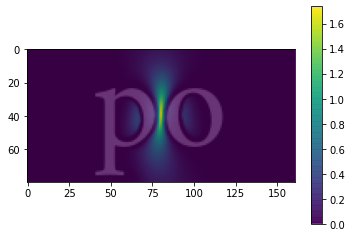

loss_penalty tf.Tensor(0.58109415, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(1.7377046, shape=(), dtype=float32)


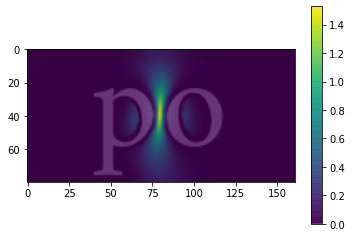

loss_penalty tf.Tensor(0.94391817, shape=(), dtype=float32) for distance 1.0 thanks to value tf.Tensor(1.5284455, shape=(), dtype=float32)


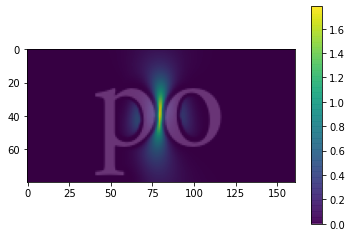

loss_penalty tf.Tensor(0.5135431, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(1.7833807, shape=(), dtype=float32)


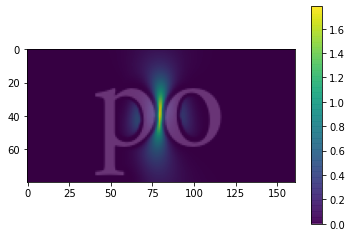

loss_penalty tf.Tensor(0.5135431, shape=(), dtype=float32) for distance tf.Tensor(-0.9792261, shape=(), dtype=float32) thanks to value tf.Tensor(1.7833807, shape=(), dtype=float32)


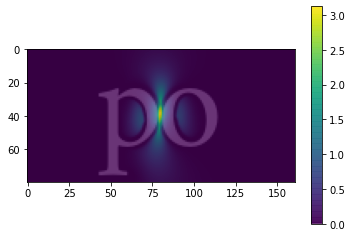

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance -4.2360680251559995 thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


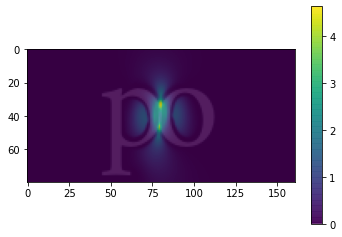

loss_penalty tf.Tensor(4.575198, shape=(), dtype=float32) for distance -8.472136091015262 thanks to value tf.Tensor(4.6389713, shape=(), dtype=float32)


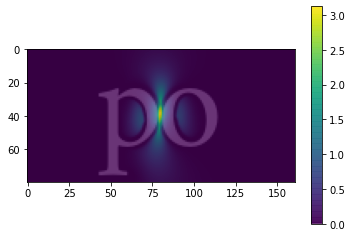

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance -4.2360680251559995 thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


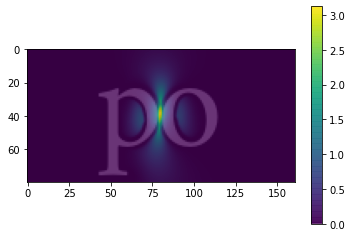

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance -5.854101999999998 thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


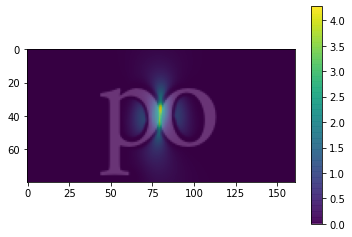

loss_penalty tf.Tensor(3.1514988, shape=(), dtype=float32) for distance -6.854102009608734 thanks to value tf.Tensor(4.275246, shape=(), dtype=float32)


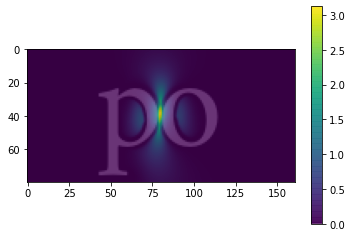

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.045085, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


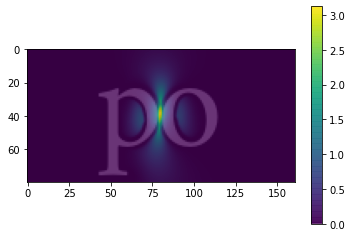

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.354102, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


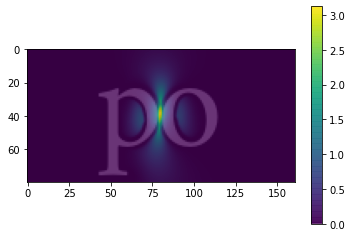

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.545085, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


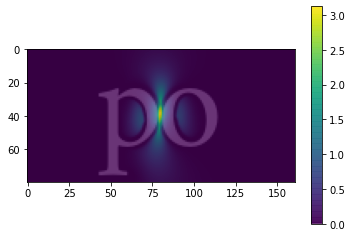

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.663119, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


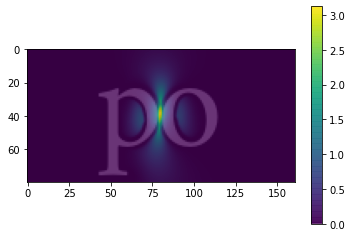

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.736068, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


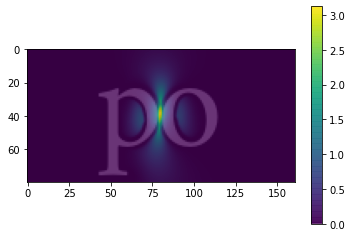

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.7811527, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


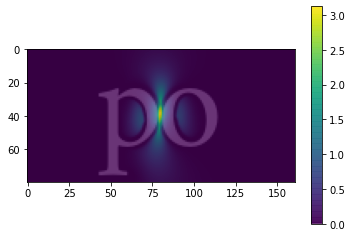

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.8090167, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


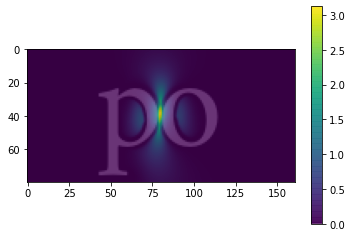

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.8262377, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)
Best distance for p o : tf.Tensor(-5.8262377, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181414, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(2.3896306, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.10167949, shape=(), dtype=float32) for distance 1.0 thanks to value tf.Tensor(2.1811278, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.15647112, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(2.8955643, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181414, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(2.3896306, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181414, shape=(), dtype=float32) for distance -0.618033974844 thanks to value tf.Tensor(2.3896306, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181

In [ ]:
# PARAMETERS

kk = 2.8
cp = 0.2
cn = 0.25
v1_v4_scale_weights = tf.tile(tf.constant([.04, .1, .13, .04, .01])[:, None], [1, n_v4_scales]) # includes the CSF
v1_v4_scale_weights = tf.ones((n_v1_scales, n_v4_scales)) # An alternative for the CSF.
v1_v4_orientation_weights = tf.ones((2*n_v1_orientations, n_v4_scales))

k = tf.constant([2.4] * n_v4_scales)
b = (0.7 ** (2.4 * tf.range(n_v4_scales, dtype=tf.float32)))

# Skeleton loss penalty
blurwidths = 0.5 / 100.
n = -.2
loss_penalties = tf.constant([0.5, 1.6, 1.5, 0.37, 0.1, 0.01, 0.01, 0.01])
skeleton_loss_target = 2.5

f_e = tf.constant([0.95, 1.0, 1.2, 0.95, 0.95, 1., 1.1, 1.0])[None, :, None, None]
f_a = tf.constant([0.95, 1.0, 1.2, 0.95, 0.95, 1., 1.1, 1.0])[None, :, None, None]
d_e = tf.constant([1., 1., 1., 1., 1., 1., 1., 1.])[None, :, None, None]
d_a = tf.constant([1.025, 1.01, 0.8, 0.925, 1., 0.97, 0.875, 0.93])[None, :, None, None]

orientation_correlators = np.zeros((8, 8)).astype(np.float32)
orientation_correlators[7,2:5] = 0.125
orientation_correlators[7,5] = 0.2
orientation_correlators[0,2] = 0.075
orientation_correlators[0,3:5] = 0.05
orientation_correlators[1,2:5] = 0.05
orientation_correlators[1,5] = 0.15
orientation_correlators[2,4:7] = 0.1
#orientation_correlators[4,0] = 0

def pair_at_distance(d, l, r):
    (lt, rt) = get_pair_translations(l, r, d)
    #v1_l = translate_4d_image(glyph_v1_responses[l], np.array([lt]))[0, ...]
    #v1_r = translate_4d_image(glyph_v1_responses[r], np.array([rt]))[0, ...]
    v4d_l = translate_4d_image(glyph_v4_distances[l], np.array([lt]))[0, ...]
    v4d_r = translate_4d_image(glyph_v4_distances[r], np.array([rt]))[0, ...]
    v4f_l = translate_4d_image(glyph_v4_fullnesses[l], np.array([lt]))[0, ...]  # <s, o, h, w>
    v4f_r = translate_4d_image(glyph_v4_fullnesses[r], np.array([rt]))[0, ...]
    g_l = translate_4d_image(glyph_images[l][None, None, :, :], np.array([lt]))[0, 0, 0, :, :]
    g_r = translate_4d_image(glyph_images[r][None, None, :, :], np.array([rt]))[0, 0, 0, :, :]
    #v1_p = v1_l + v1_r
    #v1c_l, v1c_r, v1c_p = tf.abs(v1_l), tf.abs(v1_r), tf.abs(v1_p)
    #v4g_l, v4g_r, v4g_p = g_response(v1c_l), g_response(v1c_r), g_response(v1c_p)

    fl = (tf.nn.relu(v4f_l) + eps) ** f_e * f_a
    fr = (tf.nn.relu(v4f_r) + eps) ** f_e * f_a
    dl = (tf.nn.relu(v4d_l) + eps) ** d_e * d_a
    dr = (tf.nn.relu(v4d_r) + eps) ** d_e * d_a

    fullness_product = fl[:, :, None, :, :] * fr[:, None, :, :, :]
    dl_s = tf.tile(dl[:, :, None, :, :], [1, 1, 2 * n_v1_orientations, 1, 1])
    dr_s = tf.tile(dr[:, None, :, :, :], [1, 2 * n_v1_orientations, 1, 1, 1])

    d_diff = tf.abs(dl_s - dr_s) + eps
    d_sum = (tf.nn.relu(dl_s + dr_s) + eps) / 2

    distance_factor = tf.exp(-d_diff**2/(eps+.1*d_sum)) / (eps + d_sum)

    losses = tf.einsum("soqhw,soqhw,oq->shw", fullness_product, distance_factor, orientation_correlators / tf.reduce_sum(orientation_correlators))[0:1, None, :, :] / 100000

    if True:
        losses_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses, 0.), [2, 3]))
        losses_filters = make_losses_filters(eps + blurwidths)[0, 0, ...]
        losses_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses_filters, eps), [2, 3]))
        losses_filtered = losses #tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(losses_fft * losses_filters_fft), [2, 3]))

    if False: 
        pln = losses_filtered * 10 ** (n * 10)
        expd = tf.exp(pln - tf.reduce_max(pln, [2,3], keepdims=True))
        softmax_weights = expd / (eps + tf.reduce_sum(expd, axis=[2,3], keepdims=True))
        worst_skeleton_loss_penalty = losses_filtered * softmax_weights
    
        #loss_penalty = (tf.reduce_sum(worst_skeleton_loss_penalty) - 60) ** 2
    loss_penalty = (tf.reduce_max(losses_filtered[0:1, 0, :, :]) - 2.5) ** 2
    if (l == "p") and True:
        #print(tf.reduce_max(losses_filtered[0:1, 0, :, :]))
        plt.imshow(g_l + g_r, cmap="gray")
        #plt.imshow(worst_skeleton_loss_penalty[0, 0, :, :], alpha=0.8)
        plt.imshow(losses_filtered[0, 0, :, :], alpha=0.8)
        #plt.imshow(losses[0, 0, :, :], alpha=0.8)
        plt.colorbar()
        plt.show()

#    relevance = 1. - (tf.abs(v4g_l - v4g_r)/(eps + v4g_l + v4g_r)) ** 1.3
#
#    attention_attraction_rates = v4g_p * channel_attention_attraction_rate * relevance * yfn / (eps + tf.reduce_min(channel_attention_attraction_rate))
#
#    attention_attraction_pool_local = tf.einsum("chw,qc->qhw", attention_attraction_rates ** g, w_local)
#    attention_attraction_pool_global = tf.einsum("chw,qc->q", attention_attraction_rates ** g, w_global)[:, None, None]
#    probability_of_grouping_feedback = attention_attraction_rates ** g / (beta ** g + attention_attraction_pool_local + attention_attraction_pool_global)
#    
#    feedback_strength = v4g_p ** fk * fb
#
#    mean_grouping_strength = tf.reduce_sum(probability_of_grouping_feedback * feedback_strength)
    print("loss_penalty", loss_penalty, "for distance", d, "thanks to value", tf.reduce_max(losses_filtered[0:1, 0, :, :]))
    return loss_penalty

def find_best_distance(l, r):
    best_distance = minimize_scalar(pair_at_distance, args=(l, r), options={"maxiter": 10}).x

    print("Best distance for", l, r, ":", best_distance)


if False:
    find_best_distance("N", "N")
    find_best_distance("L", "T")
    find_best_distance("N", "T")
    find_best_distance("O", "T")
    find_best_distance("R", "S")
    find_best_distance("C", "X")
else:
    find_best_distance("l", "l")
    find_best_distance("p", "o")
    find_best_distance("d", "b")
    find_best_distance("d", "h")
    find_best_distance("m", "i")
    find_best_distance("a", "a")
